# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [476]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

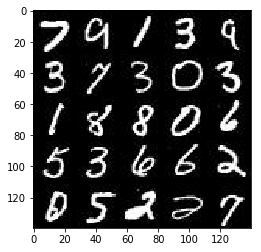

In [477]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

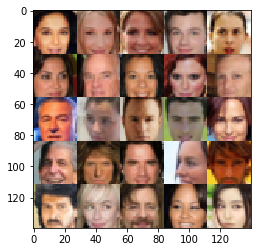

In [478]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [479]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [480]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # create real input images, z, and learning rate placeholders
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(tf.float32)
    
    # :return tuple of (tensor of real input images, tensor of z data, learning rate)
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [481]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # convolution network with one fully connected layer at the end with sigmoid output
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28s28x(1[letters] or 3[faces])
        #kernel size is an integer or tuple of 2 integers spec the w&h of the 2d Conv window
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding='valid')
        relu1 = tf.maximum(alpha * x1, x1)
        # Now 13x13x64
        
        # next layer - 6x6x128
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=3, strides=2, padding='valid') 
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
 
        # next layer - 3x3x256        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=2, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it and connect to a single sigmoid unit
        flat = tf.reshape(relu3, (-1, 3*3*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [482]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha=0.2
    #take the input and double it's size using strides of two & halving depth using transposed convolution
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z,  3 * 3 * 512, activation=None)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)
        print(x1.shape)
        # shape now (?, 3, 3, 512)
        
        x2 = tf.layers.conv2d_transpose(
                                        x1,
                                        256,
                                        2,
                                        strides = 2,
                                        padding = 'valid'
                                        )
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        print(x2.shape)
        # shape now (?, 6, 6, 256)
        
        x3 = tf.layers.conv2d_transpose(x2,
                                        128,
                                        3,
                                        strides=2,
                                        padding='valid'
                                       )
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        print(x3.shape)
        # shape now (?, 13, 13, 128)
        
        #end generator size should be the size of the image used so 28x28x3
        # no batch normalization on the final one
        logits = tf.layers.conv2d_transpose(x3,
                                            out_channel_dim,
                                            4,
                                            strides=2,
                                            padding='valid'
                                           )
        print(logits)
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("conv2d_transpose_6/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [483]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # keep getting error generator() got an unexpected keyword argument 'alpha' so deleted alpha from here
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
      
    # calculate total loss
    d_loss = d_loss_real + d_loss_fake
    
    # return discriminator loss, generator loss
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 4), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [484]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1
                                            ).minimize(g_loss, var_list=g_vars)
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate,
                                        beta1=beta1
                                        ).minimize(d_loss,var_list=d_vars)
        
    # return discrimator training op & generator training op
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [485]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [486]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: use model_inputs, model_loss, & model_opt
    _, image_width, image_height, out_channel_dim = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # the values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 
                # dimensional images But the output from the tanh used in the generator gives an output 
                # between -1 and 1. Rescale the image accordingly
                image_input = 2 * batch_images
                steps += 1

                #sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_opt, feed_dict={
                                                input_real: batch_images,
                                                input_z: batch_z,
                                                lr: learning_rate
                                                })
                
                _ = sess.run(g_opt, feed_dict={
                                                input_real: batch_images,
                                                input_z: batch_z,
                                                lr: learning_rate
                                              })
                _ = sess.run(g_opt, feed_dict={
                                                input_real: batch_images,
                                                input_z: batch_z,
                                                lr: learning_rate
                                              })
                
                if steps & 10 == 0:
                    train_loss_d = d_loss.eval({
                                                input_z:batch_z,
                                                input_real: batch_images
                                               })
                    train_loss_g = g_loss.eval({
                                                input_z: batch_z
                                                })
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                    "Discriminator Loss: {:.4f}...".format(train_loss_d),
                    "Generator Loss: {:.4f}".format(train_loss_g))
                    
                #print the generator output every 100 batches.
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Epoch 1/2... Discriminator Loss: 3.4843... Generator Loss: 0.0441
Epoch 1/2... Discriminator Loss: 3.5269... Generator Loss: 0.0362
Epoch 1/2... Discriminator Loss: 3.5112... Generator Loss: 0.0363
Epoch 1/2... Discriminator Loss: 3.6292... Generator Loss: 0.0353
Epoch 1/2... Discriminator Loss: 3.6624... Generator Loss: 0.0361
Epoch 1/2... Discriminator Loss: 3.3848... Generator Loss: 0.0504
Epoch 1/2... Discriminator Loss: 3.3637... Generator Loss: 0.0497
Epoch 1/2... Discriminator Loss: 2.9023... Generator Loss: 0.0937
Epoch 1/2... Discriminator Loss: 2.8518... Generator Loss: 0.0985
Epoch 1/2... Discriminator Loss: 2.7927... Generator Loss: 0.1196
Epoch 1/2... Discriminator Loss: 2.8178... Generator Loss: 0.1190
Epoch 1/2... Discriminator Loss: 2.8948... Generator Loss: 0.1902
Epoch 1/2... Discriminator Loss: 2.8969... Generator Loss: 0.2015
Epoch 1/2

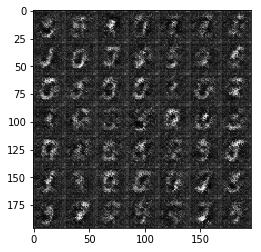

Epoch 1/2... Discriminator Loss: 1.7437... Generator Loss: 0.4906
Epoch 1/2... Discriminator Loss: 1.7131... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 1.6292... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 1.5843... Generator Loss: 0.5716
Epoch 1/2... Discriminator Loss: 1.6335... Generator Loss: 0.5506
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.5845... Generator Loss: 0.5657
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.5790
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.6223
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 1.4288... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.6200
Epoch 1/2.

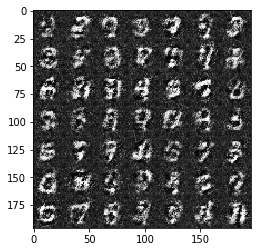

Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.2649... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 0.6846
Epoch 1/2.

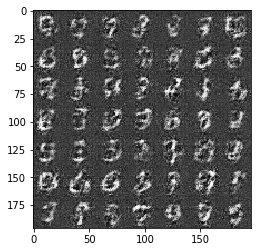

Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 0.9745... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 0.7586
Epoch 1/2.

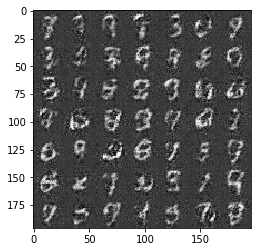

Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 1.2727
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 0.4119
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 0.7412... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 1.4936
Epoch 1/2... Discriminator Loss: 1.5347... Generator Loss: 0.3226
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 1.0889
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 1.6612
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 0.4803
Epoch 1/2.

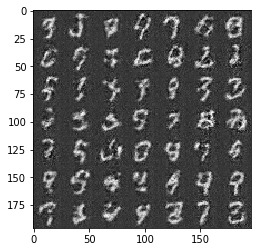

Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 0.9036
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.0264
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.4143
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 0.6759... Generator Loss: 1.5207
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 0.6855... Generator Loss: 1.6088
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.5416
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.7299
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.5416
Epoch 2/2.

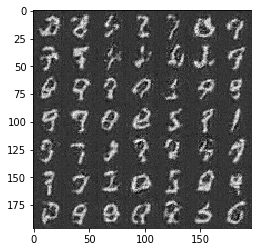

Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.6218
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.3735
Epoch 2/2... Discriminator Loss: 0.6928... Generator Loss: 1.3600
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 0.6457... Generator Loss: 1.7970
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.7821
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 0.7247... Generator Loss: 1.6557
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 0.5027
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 1.1530
Epoch 2/2... Discriminator Loss: 0.5058... Generator Loss: 1.4933
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 0.6036... Generator Loss: 1.7036
Epoch 2/2.

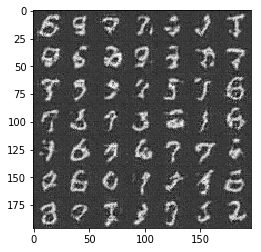

Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 1.3727
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 0.6726... Generator Loss: 1.7308
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 1.9439
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.0871
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.2195
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.3714
Epoch 2/2... Discriminator Loss: 0.6564... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 0.6537... Generator Loss: 1.8572
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.4648
Epoch 2/2.

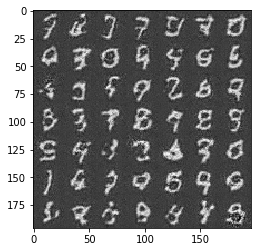

Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 1.0881
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 0.6071... Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 0.4876... Generator Loss: 1.5072
Epoch 2/2... Discriminator Loss: 0.7077... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.2396
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.4031
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 1.7843
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.6298
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 1.2392
Epoch 2/2.

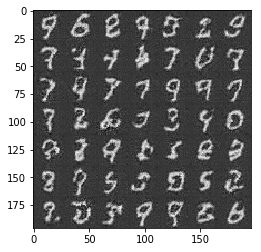

Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.0696
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 1.7895
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 0.6241... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 0.3813... Generator Loss: 2.1121


In [487]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Epoch 1/1... Discriminator Loss: 3.8480... Generator Loss: 0.0425
Epoch 1/1... Discriminator Loss: 3.8044... Generator Loss: 0.0290
Epoch 1/1... Discriminator Loss: 3.7890... Generator Loss: 0.0294
Epoch 1/1... Discriminator Loss: 3.8282... Generator Loss: 0.0320
Epoch 1/1... Discriminator Loss: 3.8091... Generator Loss: 0.0304
Epoch 1/1... Discriminator Loss: 3.8403... Generator Loss: 0.0327
Epoch 1/1... Discriminator Loss: 3.8063... Generator Loss: 0.0341
Epoch 1/1... Discriminator Loss: 3.7532... Generator Loss: 0.0425
Epoch 1/1... Discriminator Loss: 3.6404... Generator Loss: 0.0446
Epoch 1/1... Discriminator Loss: 3.6696... Generator Loss: 0.0472
Epoch 1/1... Discriminator Loss: 3.6182... Generator Loss: 0.0504
Epoch 1/1... Discriminator Loss: 3.2980... Generator Loss: 0.0777
Epoch 1/1... Discriminator Loss: 3.3454... Generator Loss: 0.0813
Epoch 1/1

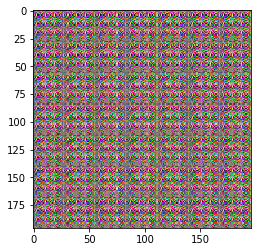

Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.8795... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.8544... Generator Loss: 0.4351
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8980
Epoch 1/1.

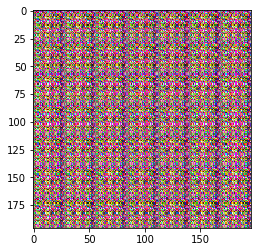

Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.2635
Epoch 1/1.

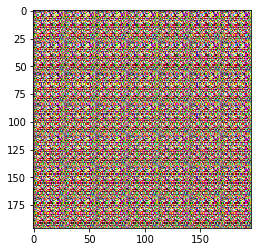

Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.4291
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1164
Epoch 1/1.

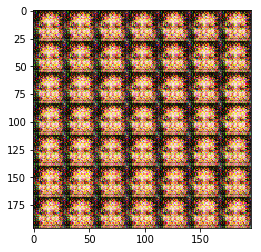

Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.1160
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.8123
Epoch 1/1.

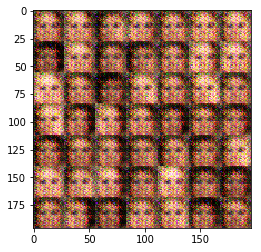

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.5949... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7259
Epoch 1/1.

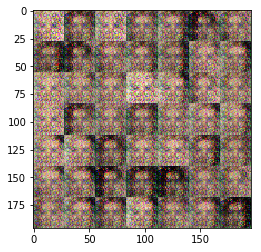

Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.8131... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.7434... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.6762... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.6292... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.8165... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.8242... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.7294... Generator Loss: 0.5850
Epoch 1/1.

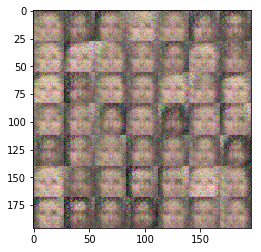

Epoch 1/1... Discriminator Loss: 1.8380... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.8705... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.7800... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.7323... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.7846... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.9310... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.7788... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.7941... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.5293
Epoch 1/1.

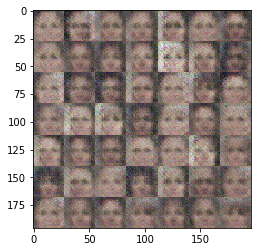

Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.6261... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.6962... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.6758... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.6476... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.6116
Epoch 1/1.

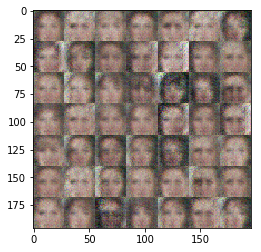

Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.6236
Epoch 1/1.

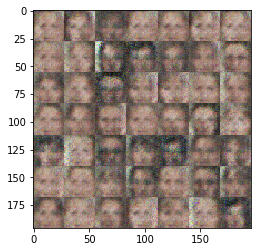

Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.6183
Epoch 1/1.

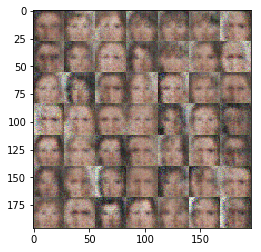

Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6280
Epoch 1/1.

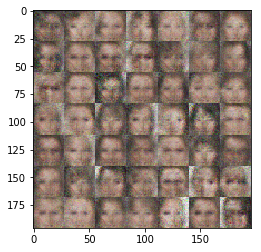

Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6346
Epoch 1/1.

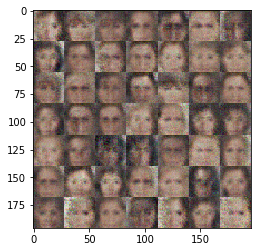

Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6673
Epoch 1/1.

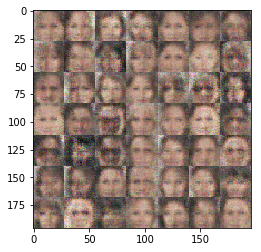

Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6578
Epoch 1/1.

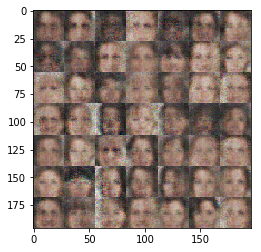

Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7008
Epoch 1/1.

In [488]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.